In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from scipy import linalg

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm import tnrange
import seaborn as sns
import pandas as pd
import numpy as np
from torchsummary import summary
import torchvision

import sys
from torch.utils.tensorboard import SummaryWriter

from generative_metric import compute_generative_metric

In [2]:
sys.path.insert(0, '../models/')

In [3]:
from CVAE_first import CVAE
from CVAE_first import idx2onehot
from sample import Sample


In [4]:
sys.path.insert(0, '../losses/')

In [5]:
from ELBO import calculate_loss

In [6]:
sys.path.insert(0, '../metrics/')

In [7]:
from inception import InceptionV3
from calculate_fid import get_activations, calculate_frechet_distance
from blur import calc_blur

In [8]:
from train import train
from test import test

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transforms = transforms.Compose([transforms.ToTensor()])

In [10]:
BATCH_SIZE=50
N_EPOCHS = 15           # times to run the model on complete data
INPUT_DIM = 28 * 28 * 3     # size of each input
HIDDEN_DIM = 1024
IMAGE_CHANNELS = 3# hidden dimension
LATENT_DIM = 10        # latent vector dimension
N_CLASSES = 15          # number of classes in the data
lr = 1e-3


In [11]:
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [12]:
sys.path

['../metrics/',
 '../models/',
 '../losses/',
 '../models/',
 '../losses/',
 '../metrics/',
 '../losses/',
 '.',
 '../models/',
 '../metrics/',
 '../models/',
 '/home/ritvik.vasan/CVAE/run_models',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python37.zip',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/lib-dynload',
 '',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages',
 '/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/IPython/extensions',
 '/home/ritvik.vasan/.ipython']

In [13]:
best_test_loss = float('inf')

modelt = CVAE(IMAGE_CHANNELS,N_CLASSES, HIDDEN_DIM, LATENT_DIM, )

optimizert = optim.Adam(modelt.parameters(), lr=lr)

dataframe = {'epoch': [], 'train_losses': [], 'train_rcl_losses': [], 'train_kl_losses': [], 'test_losses': [],
             'test_rcl_losses': [], 'test_kl_losses': [], 'fid_any_color_any_digit': [],
             'fid_color_blue_any_digit': [], 'fid_any_color_digit_0': [], 
             'fid_color_blue_digit_zero': [],
             'blur': []}

data2 = {'epoch': [], 'n_dim': [], 'kld_avg_dim': []}


In [14]:
# import torchvision
# network = modelt
# images, labels = next(iter(train_iterator))
# grid = torchvision.utils.make_grid(images)

In [15]:
tb.add_graph?

Object `tb.add_graph` not found.


In [14]:
tb = SummaryWriter(log_dir = './runs_2/')
# tb.add_image('images', grid)
# tb.add_graph(network, images)

In [16]:
for e in tnrange(N_EPOCHS,desc='Epochs'):

    train_loss, tr_rcl_loss, tr_kld_loss, tr_kl_per_lt = train(modelt, optimizert, train_iterator, device, BATCH_SIZE)
    test_loss, test_rcl_loss, test_kld_loss, test_kl_per_lt, blur = test(modelt, optimizert, test_iterator, device, BATCH_SIZE)

    with torch.no_grad():
        fid1, grid, grid2 = compute_generative_metric(test_iterator, modelt, device, LATENT_DIM, BATCH_SIZE, 
                                    color_value= None, digit_value=None)

        tb.add_image('Real image', grid, global_step = e)
        tb.add_image('Generated images', grid2, global_step = e)
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid, (1,2,0)))
#     plt.show()
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid2.cpu(), (1,2,0)))
#     plt.show()
    
        fid2, grid, grid2 = compute_generative_metric(test_iterator, modelt, device, LATENT_DIM, BATCH_SIZE, 
                                    color_value= 0, digit_value=None)

        tb.add_image('Real image', grid, global_step = e)
        tb.add_image('Generated images', grid2, global_step = e)    

#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid, (1,2,0)))
#     plt.show()
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid2.cpu(), (1,2,0)))
#     plt.show()
    
        fid3, grid, grid2 = compute_generative_metric(test_iterator, modelt, device, LATENT_DIM, BATCH_SIZE, 
                                    color_value= None, digit_value=5)


        tb.add_image('Real image', grid, global_step = e)
        tb.add_image('Generated images', grid2, global_step = e)
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid, (1,2,0)))
#     plt.show()
    
#     plt.figure(figsize = (15,  15))
#     plt.imshow(np.transpose(grid2.cpu(), (1,2,0)))
#     plt.show()
    
        fid4, grid, grid2 = compute_generative_metric(test_iterator, modelt, device, LATENT_DIM, BATCH_SIZE, 
                                    color_value= 0, digit_value=5)


        tb.add_image('Real image', grid, global_step = e)
        tb.add_image('Generated images', grid2, global_step = e)
    train_loss /= len(train_dataset)
    tr_rcl_loss /= len(train_dataset)
    tr_kld_loss /= len(train_dataset)
    test_loss /= len(test_dataset)
    test_rcl_loss /= len(test_dataset)
    test_kld_loss /= len(test_dataset)
    
    tb.add_scalar('Test loss', test_loss, e)
    tb.add_scalar('Train loss', train_loss, e)
    tb.add_scalar('Test KLD loss', test_kld_loss, e)
    tb.add_scalar('Train KLD loss', tr_kld_loss, e)
    tb.add_scalar('Test RCL loss', test_rcl_loss, e)
    tb.add_scalar('Train RCL loss', tr_rcl_loss, e)
    tb.add_scalar('FID any color and digit', fid1, e)
    tb.add_scalar('FID color red only', fid2, e)
    tb.add_scalar('FID digit 5 only', fid3, e)
    tb.add_scalar('FID red 5 only', fid4, e)
    
    tb.add_histogram('encoder.conv1.conv.bias', modelt.encoder.conv1.conv.bias, e)
    tb.add_histogram('encoder.conv1.conv.weight', modelt.encoder.conv1.conv.weight, e)
    tb.add_histogram('encoder.conv1.conv.weight.grad', modelt.encoder.conv1.conv.weight.grad, e)
    
    tb.add_histogram('encoder.conv2.conv.bias', modelt.encoder.conv2.conv.bias, e)
    tb.add_histogram('encoder.conv2.conv.weight', modelt.encoder.conv2.conv.weight, e)
    tb.add_histogram('encoder.conv2.conv.weight.grad', modelt.encoder.conv2.conv.weight.grad, e)
    
    tb.add_histogram('encoder.conv3.conv.bias', modelt.encoder.conv3.conv.bias, e)
    tb.add_histogram('encoder.conv3.conv.weight', modelt.encoder.conv3.conv.weight, e)
    tb.add_histogram('encoder.conv3.conv.weight.grad', modelt.encoder.conv3.conv.weight.grad, e)
    
    tb.add_histogram('encoder.mu.bias', modelt.encoder.mu.bias, e)
    tb.add_histogram('encoder.mu.weight', modelt.encoder.mu.weight, e)
    tb.add_histogram('encoder.mu.weight.grad', modelt.encoder.mu.weight.grad, e)

    tb.add_histogram('encoder.var.bias', modelt.encoder.var.bias, e)
    tb.add_histogram('encoder.var.weight', modelt.encoder.var.weight, e)
    tb.add_histogram('encoder.var.weight.grad', modelt.encoder.var.weight.grad, e)

       
    tb.add_histogram('decoder.latent_to_hidden.bias', modelt.decoder.latent_to_hidden.bias, e)
    tb.add_histogram('decoder.latent_to_hidden.weight', modelt.decoder.latent_to_hidden.weight, e)
    tb.add_histogram('decoder.latent_to_hidden.weight.grad', modelt.decoder.latent_to_hidden.weight.grad, e)
        
    tb.add_histogram('decoder.conv1.conv.bias', modelt.decoder.conv1.conv.bias, e)
    tb.add_histogram('decoder.conv1.conv.weight', modelt.decoder.conv1.conv.weight, e)
    tb.add_histogram('decoder.conv1.conv.weight.grad', modelt.decoder.conv1.conv.weight.grad, e)
    
    tb.add_histogram('decoder.conv2.conv.bias', modelt.decoder.conv2.conv.bias, e)
    tb.add_histogram('decoder.conv2.conv.weight', modelt.decoder.conv2.conv.weight, e)
    tb.add_histogram('decoder.conv2.conv.weight.grad', modelt.decoder.conv2.conv.weight.grad, e)
    
    tb.add_histogram('decoder.conv3.conv.bias', modelt.decoder.conv3.conv.bias, e)
    tb.add_histogram('decoder.conv3.conv.weight', modelt.decoder.conv3.conv.weight, e)
    tb.add_histogram('decoder.conv3.conv.weight.grad', modelt.decoder.conv3.conv.weight.grad, e)

    dataframe['epoch'].append(e)
    dataframe['train_losses'].append(train_loss)
    dataframe['train_rcl_losses'].append(tr_rcl_loss)
    dataframe['train_kl_losses'].append(tr_kld_loss)
    dataframe['test_losses'].append(test_loss)
    dataframe['test_rcl_losses'].append(test_rcl_loss)
    dataframe['test_kl_losses'].append(test_kld_loss)

    dataframe['fid_any_color_any_digit'].append(fid1)
    dataframe['fid_color_blue_any_digit'].append(fid2)
    dataframe['fid_any_color_digit_0'].append(fid3)
    dataframe['fid_color_blue_digit_zero'].append(fid4)
    dataframe['blur'].append(blur)
    print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Train KLD Loss: {tr_kld_loss:.2f}, Test Loss: {test_loss:.2f}, Test KLD Loss: {test_kld_loss:.2f}' )
    #sns.pairplot(data = pd.DataFrame(tr_kl_per_lt), height=3, vars=["dimension"])

    df = pd.DataFrame(tr_kl_per_lt)
    df = df.sort_values(by=['KL_Divergence'])
    n_dim = np.max(df['Latent_Dimension'])

    kld_avg_dim = np.zeros(n_dim)

    for i in range(n_dim):
        kld_avg_dim[i] = np.mean(df['KL_Divergence'][df['Latent_Dimension'] == i])
    kld_avg_dim = np.sort(kld_avg_dim)[::-1]

    data2['epoch'].append(e)
    data2['n_dim'].append(n_dim)
    data2['kld_avg_dim'].append(kld_avg_dim)

    #     print(f'Epoch {e}, Train RCL loss: {tr_rcl_loss:.2f}, Test RCL Loss: {test_rcl_loss:.2f}')
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        patience_counter = 1
    else:
        patience_counter += 1

    if patience_counter > 3:
        break
    
    print('end of epoch')
    

tb.close()        

/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 0, Train Loss: 156.90, Train KLD Loss: 9.43, Test Loss: 112.48, Test KLD Loss: 13.63
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 1, Train Loss: 108.84, Train KLD Loss: 14.66, Test Loss: 105.03, Test KLD Loss: 14.66
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 2, Train Loss: 103.90, Train KLD Loss: 15.15, Test Loss: 101.88, Test KLD Loss: 15.04
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 3, Train Loss: 101.46, Train KLD Loss: 15.39, Test Loss: 99.55, Test KLD Loss: 15.64
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 4, Train Loss: 99.78, Train KLD Loss: 15.56, Test Loss: 98.55, Test KLD Loss: 15.76
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 5, Train Loss: 98.52, Train KLD Loss: 15.68, Test Loss: 97.91, Test KLD Loss: 15.36
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 6, Train Loss: 97.51, Train KLD Loss: 15.76, Test Loss: 97.19, Test KLD Loss: 15.38
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 7, Train Loss: 96.81, Train KLD Loss: 15.84, Test Loss: 96.50, Test KLD Loss: 15.74
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 8, Train Loss: 96.18, Train KLD Loss: 15.93, Test Loss: 96.61, Test KLD Loss: 15.64
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 9, Train Loss: 95.66, Train KLD Loss: 15.96, Test Loss: 95.81, Test KLD Loss: 15.97
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 10, Train Loss: 95.23, Train KLD Loss: 16.03, Test Loss: 95.74, Test KLD Loss: 15.63
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 11, Train Loss: 94.80, Train KLD Loss: 16.07, Test Loss: 95.80, Test KLD Loss: 16.12
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 12, Train Loss: 94.52, Train KLD Loss: 16.13, Test Loss: 95.28, Test KLD Loss: 16.11
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 13, Train Loss: 94.27, Train KLD Loss: 16.16, Test Loss: 95.20, Test KLD Loss: 15.98
end of epoch


/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
../metrics/calculate_fid.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(batch, volatile=True)
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/tmp/yes/envs/ritvik_pytorch_tutorial/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See

Epoch 14, Train Loss: 93.92, Train KLD Loss: 16.16, Test Loss: 94.75, Test KLD Loss: 15.97
end of epoch



In [16]:
stats = pd.DataFrame(dataframe)

In [17]:
stats = stats.sort_values(by='epoch', ascending=False)

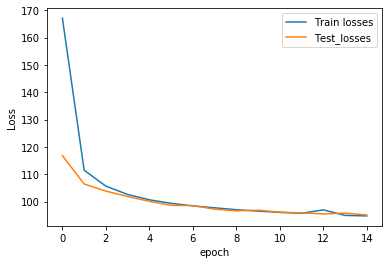

In [18]:
import seaborn as sns

sns.lineplot(data = stats, x = 'epoch', y = 'train_losses')
g = sns.lineplot(data = stats, x = 'epoch', y = 'test_losses')
g.set_ylabel('Loss')
g.legend(['Train losses', 'Test_losses'])

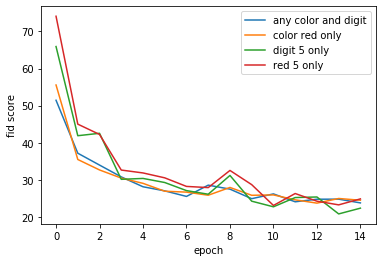

In [22]:
import seaborn as sns

sns.lineplot(data = stats, x = 'epoch', y = 'fid_any_color_any_digit')
sns.lineplot(data = stats, x = 'epoch', y = 'fid_color_blue_any_digit')
sns.lineplot(data = stats, x = 'epoch', y = 'fid_any_color_digit_0')
g = sns.lineplot(data = stats, x = 'epoch', y = 'fid_color_blue_digit_zero')
g.set_ylabel('fid score')
g.legend(['any color and digit', 'color red only', 'digit 5 only', 'red 5 only'])

In [23]:
stats

,epoch,train_losses,train_rcl_losses,train_kl_losses,test_losses,test_rcl_losses,test_kl_losses,fid_any_color_any_digit,fid_color_blue_any_digit,fid_any_color_digit_0,fid_color_blue_digit_zero,blur
14,14,95.080951,77.040487,18.040464,95.847717,78.398561,17.449156,23.794529,24.510164,22.374997,24.873771,0.010938
13,13,95.266275,77.287230,17.979045,95.402302,77.900812,17.501490,24.800173,24.984559,20.825309,23.263569,0.010677
12,12,95.519802,77.548663,17.971139,95.746873,78.048221,17.698652,24.787214,23.730962,25.387442,24.255796,0.011092
11,11,95.828409,77.858868,17.969540,96.178673,78.656551,17.522121,24.093618,24.620161,25.234608,26.320448,0.010882
10,10,96.063621,78.130076,17.933546,96.403533,78.648398,17.755134,26.217498,25.945665,22.741047,23.104978,0.011066
9,9,96.781869,78.766422,18.015447,96.601243,78.977666,17.623576,24.928565,25.845707,24.258372,28.710609,0.010652
8,8,99.476058,81.367253,18.108805,98.511504,80.593801,17.917703,27.504499,27.956192,31.191325,32.540192,0.010282
7,7,97.638144,79.884527,17.753617,97.608374,80.225068,17.383306,28.577239,25.862091,26.129651,27.917711,0.010104
6,6,98.390476,80.727914,17.662563,97.912323,80.112072,17.800251,25.539461,26.698135,27.104588,28.236682,0.010237
5,5,99.312234,81.743277,17.568957,98.605173,81.037248,17.567924,27.034794,26.943174,29.287048,30.546270,0.010490


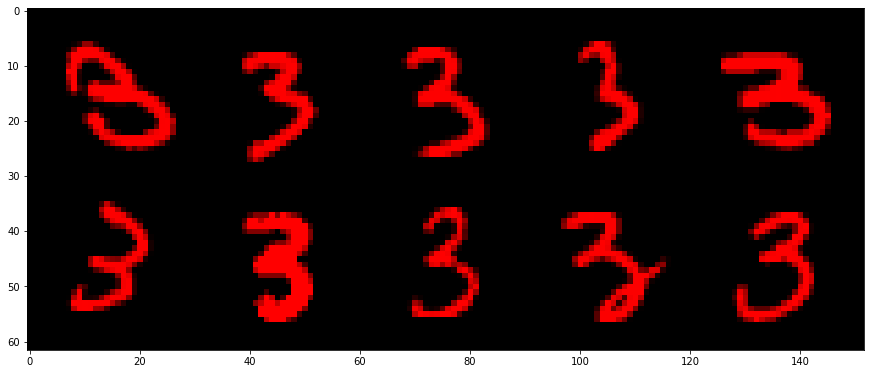

In [31]:
import torchvision
images = im[:10, :, :, :]
grid2 = torchvision.utils.make_grid(images, nrow = 5)

plt.figure(figsize = (15,  15))
plt.imshow(np.transpose(grid2.cpu(), (1,2,0)))

In [107]:
modelt.encoder.conv1.conv_condition.weight.shape

torch.Size([64, 15, 1, 1])

In [108]:
modelt.encoder.conv2.conv.weight.shape

torch.Size([128, 64, 4, 4])

In [109]:
modelt.encoder.conv2.conv_condition.weight.shape

torch.Size([128, 15, 1, 1])

In [114]:
modelt.encoder.mu.weight.shape

torch.Size([100, 1024])

In [110]:
modelt

CVAE(
  (encoder): Encoder(
    (conv1): ConditionLayer(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
      (conv_condition): Conv2d(15, 64, kernel_size=(1, 1), stride=(1, 1))
      (activation): ReLU()
    )
    (conv2): ConditionLayer(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
      (conv_condition): Conv2d(15, 128, kernel_size=(1, 1), stride=(1, 1))
      (activation): ReLU()
    )
    (conv3): ConditionLayer(
      (conv): Conv2d(128, 1024, kernel_size=(4, 4), stride=(2, 2))
      (conv_condition): Conv2d(15, 1024, kernel_size=(1, 1), stride=(1, 1))
      (activation): ReLU()
    )
    (mu): Linear(in_features=1024, out_features=100, bias=True)
    (var): Linear(in_features=1024, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (latent_to_hidden): Linear(in_features=115, out_features=1024, bias=True)
    (conv1): ConditionLayer(
      (conv): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
      (conv_condition): Conv

In [111]:
modelt.decoder.latent_to_hidden.weight.shape

torch.Size([1024, 115])

In [113]:
modelt.decoder.conv2.conv.weight.shape

torch.Size([128, 64, 5, 5])